In [48]:
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
import numpy as np

# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
data_path = './data/master_4Mayhew.xlsx'
df = pd.read_excel(data_path)
df.set_index('SMILES', inplace=True)
y=df['label'] # labels, independent variables
X=df.drop(['label'], axis=1) # features, dependent variables

df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,10.191572,9.610016,0,0,16.402096,2.535251,4.795559,16.402096,1.261700,3.521954,...,60.186518,178.026609,9.369822,209,23,72,89,5.506944,2.750000,False
C(=C(F)F)(C(F)(F)F)C(F)(F)F,8.786807,9.354315,0,0,11.264384,2.394170,4.788340,11.264384,0.938699,3.353751,...,43.053817,199.987226,16.665602,179,16,58,63,8.347222,2.444444,False
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],11.877237,11.411786,0,0,18.380381,2.411142,4.822284,18.380381,1.148774,3.664511,...,48.280750,228.997099,12.052479,408,25,78,90,8.277778,3.555556,False
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,15.682318,12.964430,0,0,26.034025,2.456696,4.859289,26.034025,1.301701,3.935426,...,61.882766,284.071641,8.608232,726,36,106,126,6.277778,4.388889,False
C(C(C(F)(F)F)(F)Cl)(F)Cl,7.220990,7.794227,0,0,9.758256,2.380983,4.761966,9.758256,0.975826,3.172059,...,40.351995,201.937546,18.357959,108,15,48,54,7.236111,2.062500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,35.041491,130.099380,5.656495,108,7,32,31,4.361111,2.416667,True
C=CCSS(=O)CC=C,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,35.041491,162.017307,8.527227,108,7,32,31,4.361111,2.416667,True
CCCC(=O)OCC(C)C,6.692130,6.855805,0,0,11.127090,2.052881,4.105762,11.127090,1.112709,3.123647,...,37.120200,144.115030,5.542886,143,8,38,37,5.222222,2.500000,True


# Explore the dataset

## How many missing values?

- There's 92 columns all NaNs
- 160 columns with > 90% NaNs

In [3]:
print(df.isna().mean(axis=0).nlargest(300))

SpAbs_Dt     1.000000
SpMax_Dt     1.000000
SpDiam_Dt    1.000000
SpAD_Dt      1.000000
SpMAD_Dt     1.000000
               ...   
AATS6m       0.213873
AATS6v       0.213873
AATS6se      0.213873
AATS6pe      0.213873
AATS6are     0.213873
Length: 300, dtype: float64


In [4]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")

Number of columns with all NaNs 
False    1735
True       92
dtype: int64


In [5]:
print(f"Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")

Number of columns with >0.9 NaNs 
False    1667
True      160
dtype: int64


In [6]:
print(f"Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with a NaN 
623


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

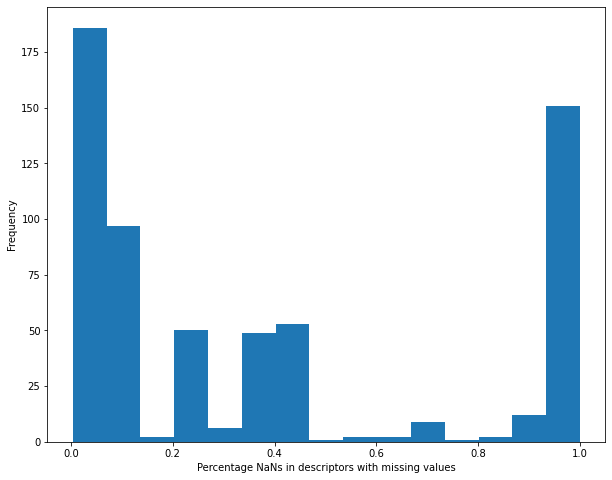

In [8]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(figsize=(10, 8), bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

In [4]:
# Remove descriptors of dataframe with > 50% nans
nans = df.isna().mean(axis=0)
# set threshold for percentage nans before we drop 
thresh = nans[nans >= 0.5]
df_corrs = df.copy()
df_corrs = df_corrs.drop(thresh.index, axis=1)
corrs = df_corrs.corr()
corrs

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
ABC,1.000000,0.984817,0.002461,0.030907,0.989272,0.728026,0.735420,0.989272,0.528869,0.920121,...,0.882940,0.938751,-0.164554,0.853747,0.958762,0.991934,0.975321,0.784337,0.952894,-0.403256
ABCGG,0.984817,1.000000,0.017644,0.022007,0.966578,0.775729,0.781912,0.966578,0.529618,0.945448,...,0.903297,0.932150,-0.185056,0.798247,0.943907,0.974350,0.955708,0.841003,0.943962,-0.397517
nAcid,0.002461,0.017644,1.000000,0.220033,-0.026060,0.013846,0.020202,-0.026060,-0.108716,0.010658,...,-0.015430,0.016209,0.020762,-0.000492,-0.026008,-0.008421,-0.021712,0.119666,-0.010251,-0.219711
nBase,0.030907,0.022007,0.220033,1.000000,0.029622,-0.004723,-0.003677,0.029622,0.019905,-0.001987,...,0.009335,0.020061,-0.052047,0.087532,0.024540,0.032639,0.033790,0.011183,0.022760,-0.129745
SpAbs_A,0.989272,0.966578,-0.026060,0.029622,1.000000,0.686444,0.694428,1.000000,0.585872,0.911180,...,0.860329,0.925137,-0.191532,0.862143,0.940489,0.973580,0.954450,0.727824,0.974252,-0.369529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,0.991934,0.974350,-0.008421,0.032639,0.973580,0.733251,0.736072,0.973580,0.509538,0.892694,...,0.888302,0.923774,-0.131867,0.836143,0.978751,1.000000,0.995078,0.768777,0.915895,-0.429542
Zagreb2,0.975321,0.955708,-0.021712,0.033790,0.954450,0.727515,0.726369,0.954450,0.500624,0.863221,...,0.884178,0.899164,-0.116056,0.813741,0.985556,0.995078,1.000000,0.740262,0.881352,-0.438329
mZagreb1,0.784337,0.841003,0.119666,0.011183,0.727824,0.614418,0.646097,0.727824,0.088493,0.745377,...,0.645128,0.825265,-0.058776,0.685694,0.779434,0.768777,0.740262,1.000000,0.773834,-0.429089
mZagreb2,0.952894,0.943962,-0.010251,0.022760,0.974252,0.625249,0.641950,0.974252,0.562932,0.897124,...,0.794815,0.920330,-0.214293,0.861128,0.883217,0.915895,0.881352,0.773834,1.000000,-0.328786


In [11]:
corrs.to_csv('descriptor-correlations.csv')  

# Extract correlation scores for important features

In [7]:
def corrs_important_features(model, X_test, model_name, nlargest=100):
    feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
    top_100 = feature_imp.nlargest(100)
    important_df = df.loc[:,top_100.index]
    corrs = important_df.corr()
    
    print(f"Extracted correlation scores for most important {nlargest} features for {model_name}")
    corrs.to_csv(f'correlations/descriptor-corrs-top{nlargest}-{model_name}.csv')  
    
    # Print heatmap for top 10
    print(f"Printing heatmap for most important 10 features")
    
    top_10 = feature_imp.nlargest(10)
    important_df_10 = df.loc[:,top_10.index]
    corrs_10 = important_df_10.corr()
    
    heatmap = sns.heatmap(corrs_10, vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test

print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


# Test Model 

In [9]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
        top_20 = feature_imp.nlargest(20)
        sns.barplot(x=top_20, y=top_20.index)
        plt.xlabel('Descriptor Importance Score')
        plt.ylabel('Descriptor')
        plt.title("Top 20 descriptors")
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred), metrics.accuracy_score(y_test, y_pred), 

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [60]:
def handle_importance(model, X_train, X_test, threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, clf 

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [11]:
def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            X_tr.fillna(X_train.mean(), inplace=True) 
            X_te.fillna(X_test.mean(), inplace=True)
    
    return X_tr, X_te

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [182]:
# set random state to 0 to allow reproducible results
clf=RandomForestClassifier(n_estimators=100, random_state=0) 

# For readability
y_train_rf = y_train
y_test_rf = y_test

## Handle NaNs RF

In [17]:
# Pick the best threshold for averaging NaN columns vs removing 
percentages = [x/100 for x in range(10, 100, 10)] 
roc_auc_nans = np.zeros((len(percentages), 10))
baseline = []
# repeat experiment because rf is random 
for j in range(10):
    # Steps of 5 from 0 to 100
    for i in range(len(percentages)):
        # True copy
        X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=percentages[i])
        clf.fit(X_train_rf, y_train_rf)
        roc, accuracy = test_model(clf, y_test_rf, X_test_rf, False)
        roc_auc_nans[i, j] = roc
        
    # Try experiment for remove all nans
    X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)
    clf.fit(X_train_rf, y_train_rf)
    roc, accuracy = test_model(clf, y_test_rf, X_test_rf, False)
    baseline.append(roc)

In [18]:
# Add baseline to roc np array 
roc_auc_nans = np.insert(roc_auc_nans, 0, baseline, axis=0)
percentages.insert(0, 0)

Text(0, 0.5, 'ROC_AUC')

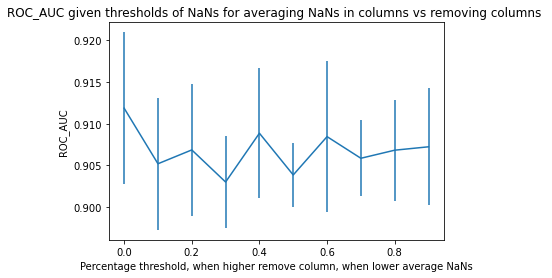

In [19]:
# Plot an error bar plot to help pick best threshold
plt.errorbar(percentages, np.mean(roc_auc_nans, axis=1), np.std(roc_auc_nans, axis=1))
plt.title("ROC_AUC given thresholds of NaNs for averaging NaNs in columns vs removing columns ")
plt.xlabel('Percentage threshold, when higher remove column, when lower average NaNs')
plt.ylabel("ROC_AUC")

It seems to have a very high standard deviation, so let's just go with removing all the columns with missing values

In [183]:
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [116]:
X_train_rf

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],8.841960,8.193289,1,0,14.383377,2.278414,4.556827,14.383377,1.198615,3.375782,...,0.000000,9.076237,42.233090,167.021858,9.824815,206,15,56,62,2.722222
CCCCCCCCCCCCCCCCO,11.313709,9.412260,0,0,20.860105,1.969616,3.939231,20.860105,1.227065,3.644675,...,0.000000,8.164226,45.799808,242.260966,4.750215,816,14,62,60,4.500000
C1(C(O1)(F)F)(C(F)(F)F)F,7.835111,8.587182,0,0,10.249622,2.654002,4.922702,10.249622,1.024962,3.316427,...,8.504918,9.973060,63.138207,165.985334,16.598533,105,13,58,72,1.875000
CC(C)(C=C)O,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,2.626363,...,0.000000,7.989899,31.665095,86.073165,5.379573,28,3,24,22,1.375000
C=CCC1=CC2=C(C=C1)OCO2,9.151948,8.339656,0,0,15.669060,2.362602,4.630996,15.669060,1.305755,3.422391,...,6.580639,9.203014,56.229240,162.068080,7.366731,197,14,60,69,2.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,2.828427,3.146264,0,0,5.464102,1.732051,3.464102,5.464102,1.092820,2.390167,...,0.000000,6.192362,25.583106,90.050321,6.003355,20,2,14,12,1.500000
CCN(CC)CC,4.242641,4.859933,0,1,8.000000,2.000000,4.000000,8.000000,1.142857,2.753451,...,0.000000,7.627057,31.941317,101.120450,4.596384,48,6,24,24,2.000000
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,10.635111,9.197041,0,0,18.814625,2.307250,4.614501,18.814625,1.343902,3.558646,...,0.000000,9.282754,45.217583,182.073165,7.586382,307,18,68,77,3.222222


Baseline test performance of Random Forest
ROC_AUC (TEST): 0.9056097560975609


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.88      0.86      0.87        50
        True       0.94      0.95      0.95       123

    accuracy                           0.92       173
   macro avg       0.91      0.91      0.91       173
weighted avg       0.92      0.92      0.92       173



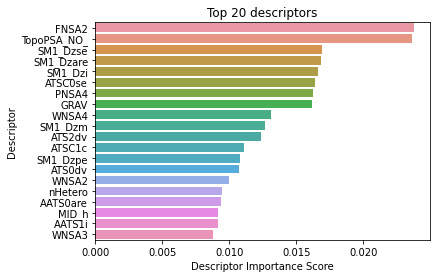

(0.9056097560975609, 0.9248554913294798)

In [184]:
clf.fit(X_train_rf, y_train_rf)
print("Baseline test performance of Random Forest")
test_model(clf, y_test_rf, X_test_rf)

## Importance Experiment

In [88]:
imp_params = [{"threshold":0, 'n':-1},
              {"threshold":0.001, 'n':-1},
              {"threshold":0.01, 'n':-1},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':500}, 
              {"threshold":-1, 'n':1000},
              {"threshold":-1, 'n':1203}]

# These descriptors must be included in every experiment 
check_descriptors = ['TopoPSA(NO)', 'nHetero', 'nHBDon', 'ATS4P', 'NsCH3', 'IC3', 'EState_VSA6', 'AATSOV', 'NsOH','SpAD_DzZ', 'SM1_DZ(v)']

In [186]:
print(f"Cross validated importance experiment with k={7}")
skf = StratifiedKFold(n_splits=5, shuffle=False)
imp_rf_df = pd.DataFrame(columns=['Name', 'Average ROC_AUC', 'Standard Deviation'])

for imp_param in imp_params: 
    name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
    print(name)
    roc_aucs_temp = []
    for i, (train_index, test_index) in enumerate(skf.split(X_train_rf, y_train_rf)):   
        X_train_fold, X_test_fold = X_train_rf.iloc[train_index], X_train_rf.iloc[test_index]
        y_train_fold, y_test_fold = y_train_rf[train_index], y_train_rf[test_index]
        clf_temp=RandomForestClassifier(n_estimators=100, random_state=0) 
        clf_temp.fit(X_train_fold, y_train_fold)
        X_train_fold, X_test_fold, clf_temp = handle_importance(clf_temp, 
                                                                X_train_fold, 
                                                                X_test_fold, 
                                                                threshold=imp_param['threshold'], 
                                                                n=imp_param['n'])
        
        if set(check_descriptors).issubset(set(X_train_fold.columns.values.tolist())): 
            continue
        
        clf_temp.fit(X_train_fold, y_train_fold)
        roc_auc, accuracy = test_model(clf_temp, y_test_fold, X_test_fold, verbose=False)
        roc_aucs_temp.append(roc_auc)
   
    
    imp_rf_df = imp_rf_df.append({'Name': name, 
                           'Average ROC_AUC':np.mean(roc_aucs_temp), 
                           'Standard Deviation':np.std(roc_aucs_temp)}, 
                            ignore_index = True)

imp_rf_df

Cross validated importance experiment with k=7
Threshold:0
Threshold:0.001
Threshold:0.01
N:100
N:500
N:1000
N:1203


,Name,Average ROC_AUC,Standard Deviation
0,Threshold:0,0.886573,0.015037
1,Threshold:0.001,0.883073,0.011635
2,Threshold:0.01,0.893522,0.013688
3,N:100,0.883522,0.013576
4,N:500,0.890032,0.019424
5,N:1000,0.892053,0.015955
6,N:1203,0.882032,0.022293


(0.879, 0.902)

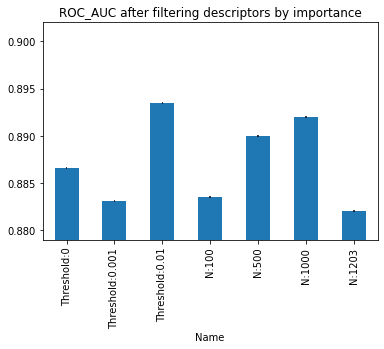

In [187]:
fig = imp_rf_df.plot(kind="bar", x="Name", y="Average ROC_AUC", xerr="Standard Deviation", title="ROC_AUC after filtering descriptors by importance", legend=False)
plt.ylim(0.879,0.902)

### Remove labels 
- best performance is with setting the threshold to 0.01

In [133]:
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                                X_train_rf, 
                                                X_test_rf, 
                                                threshold=0.01, 
                                                n=-1)

Test performance of Random Forest after removing labels
ROC_AUC (TEST): 0.9296747967479676


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



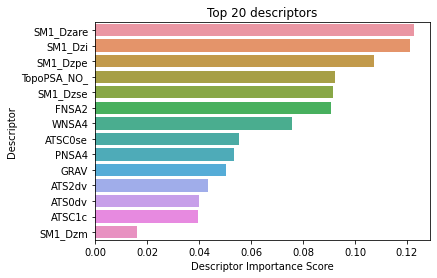

(0.9296747967479676, 0.9421965317919075)

In [134]:
clf.fit(X_train_rf, y_train_rf)
print("Test performance of Random Forest after removing labels")
test_model(clf, y_test_rf, X_test_rf)

## Tuning the hyperparamaters 

In [135]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Fitting 10 folds for each of 162 candidates, totalling 1620 fits
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Optimised test performance of Random Forest
ROC_AUC (TEST): 0.9296747967479676


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



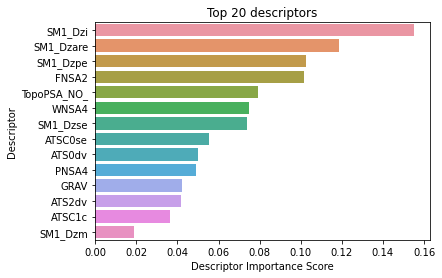

(0.9296747967479676, 0.9421965317919075)

In [167]:
# Use the grid to search for best hyperparameters
# Takes ~ 5 minutes to run 

# Number of trees in random forest - manual testing 100-1000
n_estimators = [100, 500, 1000]
# # Maximum number of levels in tree
max_depth = [None, 10, 20, 40, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# # Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion 
criterion = ['gini', 'entropy']

# Create the grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}


# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator=clf, scoring="roc_auc", param_grid = random_grid, cv = 10, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

# Print best paramaters 
print(rf_random.best_params_)

print("Optimised test performance of Random Forest")
test_model(rf_random.best_estimator_, y_test_rf, X_test_rf)

In [171]:
rf_random.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [178]:
tuned_rf= RandomForestClassifier(n_estimators=1000,
                                 min_samples_split=5,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=None,
                                 criterion='gini',
                                 bootstrap=True, 
                                 random_state=0)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(min_samples_split=5, n_estimators=1000, random_state=0)

ROC_AUC (TEST): 0.9296747967479676


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



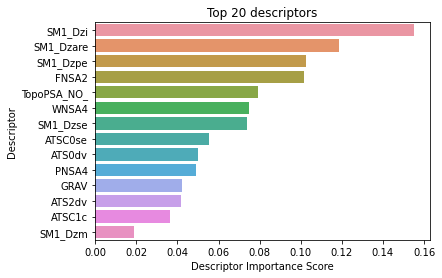

(0.9296747967479676, 0.9421965317919075)

In [179]:
test_model(tuned_rf, y_test_rf, X_test_rf)

## Extract correlation scores for important features

Extracted correlation scores for most important 500 features for random forest
Printing heatmap for most important 10 features


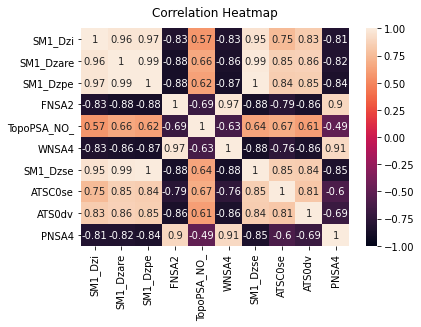

In [180]:
corrs_important_features(tuned_rf, X_test_rf, "random forest", 500)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [35]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv('data/random-forest-df.csv')  
rf_csv

,FNSA2,TopoPSA_NO_,SM1_Dzse,SM1_Dzare,SM1_Dzi,ATSC0se,PNSA4,GRAV,WNSA4,SM1_Dzm,...,SsCl,Mor21,JGI6,ETA_dPsi_B,JGI10,nFHRing,ATSC3v,Xc_6dv,Mor25p,CIC0
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,-0.915439,74.60,0.993979,1.142857,0.692537,3.054191,-16.054904,2344.195126,-5.349824,0.997062,...,0.000000,-0.317577,0.000000,0.0,0.0,0,-185.021339,0.010206,0.286626,2.738900
C(=C(F)F)(C(F)(F)F)C(F)(F)F,-1.298106,0.00,2.508000,3.121951,2.829626,4.193376,-31.248175,3079.984723,-9.026518,2.942312,...,0.000000,0.198509,0.000000,0.0,0.0,0,-188.114710,0.006749,0.070434,2.666667
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],-1.567908,149.65,2.160253,2.557003,1.887688,3.687211,-29.743377,3420.554144,-10.720464,2.172360,...,0.000000,-0.453726,0.000000,0.0,0.0,0,-267.950653,0.000000,0.289909,2.351107
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,-0.627113,32.67,0.738805,0.773658,0.755294,2.057077,-9.128078,3902.682223,-4.384569,1.195451,...,6.108366,-1.086164,0.021301,0.0,0.0,1,-197.432201,0.000000,0.754960,3.457749
C(C(C(F)(F)F)(F)Cl)(F)Cl,-1.026223,0.00,1.987068,2.184435,2.031838,3.734135,-26.660661,2814.087423,-7.618910,3.161314,...,8.209066,0.034229,0.000000,0.0,0.0,0,-123.269689,0.070590,-0.016077,1.669503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,-0.214952,26.30,0.496990,0.571429,0.346268,1.975926,-3.294040,1059.468170,-1.161034,0.498531,...,0.000000,-1.070576,0.020408,0.0,0.0,0,242.255135,0.000000,0.102175,3.258889
C=CCSS(=O)CC=C,-0.272162,17.07,0.391207,0.236534,-0.000667,1.148345,-5.106279,1564.446393,-1.820266,1.499983,...,0.000000,-0.388072,0.020408,0.0,0.0,0,-111.273560,0.000000,0.166938,2.669950
CCCC(=O)OCC(C)C,-0.222321,26.30,0.496990,0.571429,0.346268,2.012234,-3.194120,1218.316536,-1.193149,0.498531,...,0.000000,-1.074346,0.027211,0.0,0.0,0,-413.938694,0.000000,0.169612,3.461538


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [22]:
# for readibility 
y_train_xgb = y_train
y_test_xgb = y_test
X_train_xgb = X_train
X_test_xgb = X_test

## Create model

In [23]:
xgb = XGBClassifier()
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Baseline test performance of XGBoost
ROC_AUC (TEST): 0.9296747967479676


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



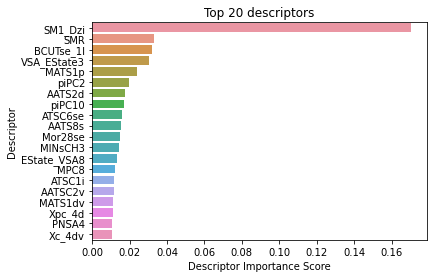

(0.9296747967479676, 0.9421965317919075)

In [59]:
# Baseline results
print("Baseline test performance of XGBoost")
test_model(xgb, y_test_xgb, X_test_xgb)

## Handle NaNs

In [60]:
# choose optimal threshold for removing columns with NaNs

percentages = [x/100 for x in range(10, 100, 10)] 
roc_auc_nans = []

# Try experiment for remove all columns with nans
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=1)
xgb.fit(X_train_xgb, y_train_xgb)
roc_base, accuracy = test_model(xgb, y_test_xgb, X_test_xgb, False)
roc_auc_nans.append(roc_base)

# Steps of 5 from 0 to 100
for i in range(len(percentages)):
    # True copy
    X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=2, thresh=percentages[i])
    xgb.fit(X_train_xgb, y_train_xgb)
    roc, accuracy = test_model(xgb, y_test_xgb, X_test_xgb, False)
    roc_auc_nans.append(roc)

In [61]:
# Add baseline to roc np array 
percentages.insert(0, 0)

Text(0, 0.5, 'ROC_AUC')

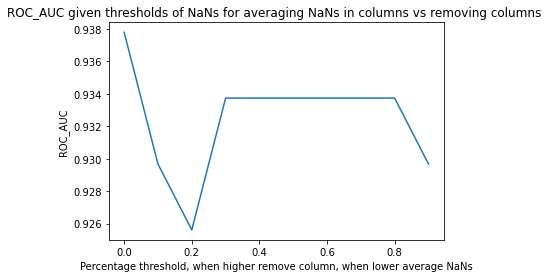

In [62]:
# Plot an error bar plot to help pick best threshold
plt.plot(percentages, roc_auc_nans)
plt.title("ROC_AUC given thresholds of NaNs for averaging NaNs in columns vs removing columns ")
plt.xlabel('Percentage threshold, when higher remove column, when lower average NaNs')
plt.ylabel("ROC_AUC")

Choose to remove columns with > 40% NaNs

In [24]:
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=2, thresh=0.4)

## Tuning paramaters with 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Step 2: Tune max_depth and min_child_weight

In [81]:
param_test1 = {
 'max_depth':range(3,11,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=0,  n_jobs = -1), 
 param_grid = param_test1, scoring='roc_auc', cv=5)

gsearch1.fit(X_train_xgb, y_train_xgb) 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=4,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror', ...),
             param_grid={'max_depth': range(3, 11, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [82]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.9641635745207173)

In [83]:
pd.DataFrame.from_dict(gsearch1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.393964,0.025100,0.030514,0.000749,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.972475,0.962374,0.979592,0.930102,0.976276,0.964164,0.017984,1
1,1.447275,0.003891,0.031400,0.000300,3,3,"{'max_depth': 3, 'min_child_weight': 3}",0.979545,0.951010,0.972959,0.954082,0.959184,0.963356,0.011047,2
2,1.505360,0.041882,0.032865,0.001361,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.966667,0.955556,0.978827,0.946684,0.966837,0.962914,0.010957,3
3,2.325305,0.089265,0.032889,0.000513,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.973737,0.939646,0.967857,0.971429,0.961735,0.962881,0.012303,4
4,2.205378,0.010381,0.032544,0.000674,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.966919,0.957323,0.967347,0.942857,0.958929,0.958675,0.008891,5
5,2.163974,0.003676,0.032488,0.000443,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.946970,0.917172,0.971684,0.968112,0.957398,0.952267,0.019566,11
6,2.278285,0.039751,0.031199,0.000465,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.931313,0.931313,0.973469,0.973469,0.972449,0.956403,0.020489,6
7,2.546748,0.150672,0.031527,0.000465,7,3,"{'max_depth': 7, 'min_child_weight': 3}",0.964899,0.917929,0.954082,0.938520,0.963520,0.947790,0.017648,12
8,2.813204,0.093999,0.033345,0.001419,7,5,"{'max_depth': 7, 'min_child_weight': 5}",0.964141,0.937374,0.947704,0.961735,0.963520,0.954895,0.010634,8
9,2.449537,0.070816,0.031283,0.000559,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.951768,0.928030,0.963010,0.976020,0.954082,0.954582,0.015772,10


ROC_AUC (TEST): 0.933739837398374


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.92      0.90      0.91        50
        True       0.96      0.97      0.96       123

    accuracy                           0.95       173
   macro avg       0.94      0.93      0.94       173
weighted avg       0.95      0.95      0.95       173



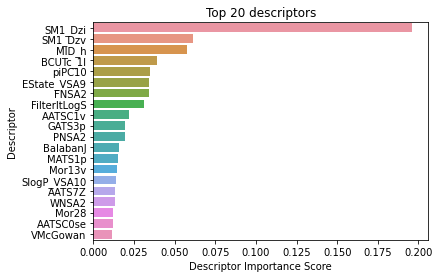

(0.933739837398374, 0.9479768786127167)

In [86]:
test_model(gsearch1.best_estimator_, y_test_xgb, X_test_xgb)

### Step 3: Tune Gamma

In [87]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth=3, min_child_weight= 1, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=0,  n_jobs = -1), 
 param_grid = param_test3, scoring='roc_auc', cv=5)

gsearch3.fit(X_train_xgb, y_train_xgb) 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=4,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror', ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [92]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.4}, 0.9688229231086375)

In [88]:
pd.DataFrame.from_dict(gsearch3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.377421,0.033030,0.029981,0.000587,0.0,{'gamma': 0.0},0.972475,0.962374,0.979592,0.930102,0.976276,0.964164,0.017984,5
1,1.526906,0.064189,0.031962,0.000610,0.1,{'gamma': 0.1},0.963636,0.963131,0.986224,0.937755,0.975510,0.965251,0.016176,4
2,1.469740,0.052183,0.033138,0.001961,0.2,{'gamma': 0.2},0.970455,0.962626,0.988010,0.945408,0.976276,0.968555,0.014231,2
3,1.535998,0.037620,0.032928,0.000434,0.3,{'gamma': 0.3},0.955808,0.962121,0.983673,0.966837,0.970153,0.967719,0.009322,3
4,1.506482,0.054075,0.031902,0.000893,0.4,{'gamma': 0.4},0.964141,0.962626,0.981633,0.964796,0.970918,0.968823,0.007000,1


ROC_AUC (TEST): 0.927479674796748


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.85      0.92      0.88        50
        True       0.97      0.93      0.95       123

    accuracy                           0.93       173
   macro avg       0.91      0.93      0.92       173
weighted avg       0.93      0.93      0.93       173



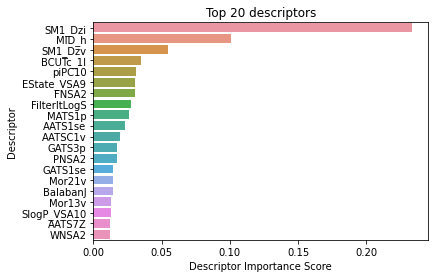

(0.927479674796748, 0.930635838150289)

In [90]:
test_model(gsearch3.best_estimator_, y_test_xgb, X_test_xgb)

### Step 4: Tune subsample and colsample_bytree


In [91]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=0,  n_jobs = -1), 
 param_grid = param_test4, scoring='roc_auc', cv=5)

gsearch4.fit(X_train_xgb, y_train_xgb) 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=4,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror', ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [93]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9687007833436404)

In [94]:
# try in 0.05 interval
param_test4 = {
 'subsample':[i/100.0 for i in range(60,90,5)],
 'colsample_bytree':[i/100.0 for i in range(60,90,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=0,  n_jobs = -1), 
 param_grid = param_test4, scoring='roc_auc', cv=5)

gsearch4.fit(X_train_xgb, y_train_xgb) 
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.75}, 0.971878478664193)

ROC_AUC (TEST): 0.9396747967479675


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.92      0.91        50
        True       0.97      0.96      0.96       123

    accuracy                           0.95       173
   macro avg       0.93      0.94      0.94       173
weighted avg       0.95      0.95      0.95       173



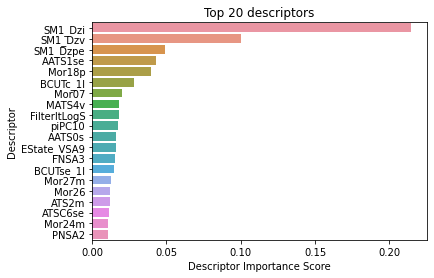

(0.9396747967479675, 0.9479768786127167)

In [96]:
test_model(gsearch4.best_estimator_, y_test_xgb, X_test_xgb)

### Step 5: Tuning Regularization Parameters


In [65]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 2, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(gamma=0.4, subsample=0.75, colsample_bytree=0.6,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=0,  n_jobs = -1), 
 param_grid = param_test6, scoring='roc_auc', cv=5)

gsearch6.fit(X_train_xgb, y_train_xgb) 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=4,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror', ...),
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                         'reg_lambda': [1e-05, 0.01, 0.1, 1, 2, 100]},
             scoring='roc_auc')

In [66]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0.01, 'reg_lambda': 1}, 0.9723575036075035)

ROC_AUC (TEST): 0.9396747967479675


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.92      0.91        50
        True       0.97      0.96      0.96       123

    accuracy                           0.95       173
   macro avg       0.93      0.94      0.94       173
weighted avg       0.95      0.95      0.95       173



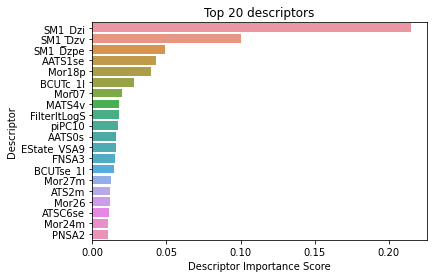

(0.9396747967479675, 0.9479768786127167)

In [67]:
test_model(gsearch6.best_estimator_, y_test_xgb, X_test_xgb)

### Final tuned paramaters


ROC_AUC (TEST): 0.9396747967479675


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.92      0.91        50
        True       0.97      0.96      0.96       123

    accuracy                           0.95       173
   macro avg       0.93      0.94      0.94       173
weighted avg       0.95      0.95      0.95       173



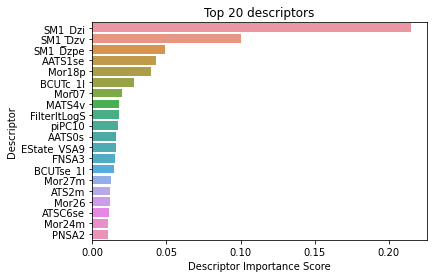

(0.9396747967479675, 0.9479768786127167)

In [26]:
tuned_xgb = XGBClassifier(reg_alpha=0.01, reg_lambda=1, gamma=0.4, subsample=0.75, colsample_bytree=0.6,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=0,  n_jobs = -1)
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Extract correlation for 'important' features

Extracted correlation scores for most important 500 features for xgb
Printing heatmap for most important 10 features


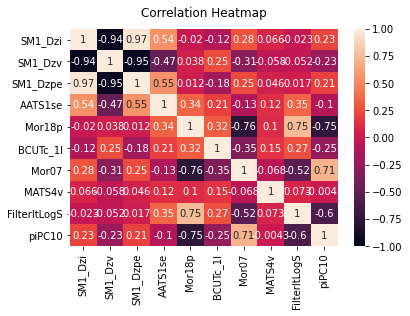

In [28]:
corrs_important_features(tuned_xgb, X_test_xgb, "xgb", 500)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with >40% missing values removed

In [34]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv('data/xgb-df.csv')  
rf_csv

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,10.191572,9.610016,0,0,16.402096,2.535251,4.795559,16.402096,1.261700,3.521954,...,9.811317,60.186518,178.026609,9.369822,209,23,72,89,5.506944,2.750000
C(=C(F)F)(C(F)(F)F)C(F)(F)F,8.786807,9.354315,0,0,11.264384,2.394170,4.788340,11.264384,0.938699,3.353751,...,9.471396,43.053817,199.987226,16.665602,179,16,58,63,8.347222,2.444444
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],11.877237,11.411786,0,0,18.380381,2.411142,4.822284,18.380381,1.148774,3.664511,...,9.637763,48.280750,228.997099,12.052479,408,25,78,90,8.277778,3.555556
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,15.682318,12.964430,0,0,26.034025,2.456696,4.859289,26.034025,1.301701,3.935426,...,9.932804,61.882766,284.071641,8.608232,726,36,106,126,6.277778,4.388889
C(C(C(F)(F)F)(F)Cl)(F)Cl,7.220990,7.794227,0,0,9.758256,2.380983,4.761966,9.758256,0.975826,3.172059,...,9.384210,40.351995,201.937546,18.357959,108,15,48,54,7.236111,2.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,7.773594,35.041491,130.099380,5.656495,108,7,32,31,4.361111,2.416667
C=CCSS(=O)CC=C,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,7.773594,35.041491,162.017307,8.527227,108,7,32,31,4.361111,2.416667
CCCC(=O)OCC(C)C,6.692130,6.855805,0,0,11.127090,2.052881,4.105762,11.127090,1.112709,3.123647,...,8.058011,37.120200,144.115030,5.542886,143,8,38,37,5.222222,2.500000
